In [1]:
import rerun as rr
import genjax
import os
import numpy as np
import jax.numpy as jnp
import jax
from b3d import Pose
import b3d
from tqdm import tqdm
import trimesh
import pytest
from PIL import Image
import matplotlib.pyplot as plt


In [2]:
PORT = 8812
rr.init("233")
rr.connect(addr=f"127.0.0.1:{PORT}")

### Define likelihood

### Render images and set up experiment

/opt/conda/envs/b3d2/lib/python3.12/site-packages/trimesh/grouping.py:99: RuntimeWarning: invalid value encountered in cast
  stacked = np.column_stack(stacked).round().astype(np.int64)


Vertices dimensions : [0.116984   0.09313101 0.081303  ]


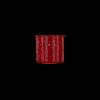

In [3]:
image_width, image_height, fx, fy, cx, cy, near, far = (
    100,
    100,
    200.0,
    200.0,
    50.0,
    50.0,
    0.01,
    10.0,
)
renderer = b3d.Renderer(image_width, image_height, fx, fy, cx, cy, near, far)

mesh_path = os.path.join(
    b3d.get_root_path(), "assets/shared_data_bucket/025_mug/textured.obj"
)
mesh = trimesh.load(mesh_path)
vertices = jnp.array(mesh.vertices)
vertices = vertices - jnp.mean(vertices, axis=0)
faces = jnp.array(mesh.faces)
vertex_colors = vertices * 0.0 + jnp.array([1.0, 0.0, 0.0])
vertex_colors = jnp.array(mesh.visual.to_color().vertex_colors)[..., :3] / 255.0
print("Vertices dimensions :", vertices.max(0) - vertices.min(0))

key = jax.random.PRNGKey(0)

camera_pose = Pose.from_position_and_target(
    jnp.array([0.6, 0.0, 0.0]), jnp.array([0.0, 0.0, 0.0])
)

cp_to_pose = lambda cp: Pose(
    jnp.array([cp[0], cp[1], 0.0]),
    b3d.Rot.from_rotvec(jnp.array([0.0, 0.0, cp[2]])).as_quat(),
)
object_library = b3d.MeshLibrary.make_empty_library()
object_library.add_object(vertices, faces, vertex_colors)

cps_to_test = [
    jnp.array([0.0, 0.0, jnp.pi]),  # Hidden
    jnp.array([0.0, 0.0, -jnp.pi / 2]),  # Side
    jnp.array([0.0, 0.0, 0.0]),  # Front
    jnp.array([0.0, 0.0, +jnp.pi / 2]),  # Side
]

text_index = 0 # 1

gt_cp = cps_to_test[text_index]

object_pose = cp_to_pose(gt_cp)

gt_img, gt_depth = renderer.render_attribute(
    (camera_pose.inv() @ object_pose)[None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)
b3d.get_rgb_pil_image(gt_img)

### Generate and split poses into batches

In [4]:

delta_cps = jnp.stack(
    jnp.meshgrid(
        jnp.linspace(-0.02, 0.02, 31),
        jnp.linspace(-0.02, 0.02, 31),
        jnp.linspace(-jnp.pi, jnp.pi, 71),
    ),
    axis=-1,
).reshape(-1, 3)
cp_delta_poses = jax.vmap(cp_to_pose)(delta_cps)

test_poses = object_pose @ cp_delta_poses

test_poses_batches = test_poses.split(10)


In [5]:
class PixelOutlier:
    @staticmethod
    def get_rgb_depth_inliers_from_observed_rendered_args(observed_rgb, rendered_rgb, observed_depth, rendered_depth, model_args):
        observed_lab = b3d.colors.rgb_to_lab(observed_rgb)
        rendered_lab = b3d.colors.rgb_to_lab(rendered_rgb)
        error = (
            jnp.linalg.norm(observed_lab[...,1:3] - rendered_lab[...,1:3], axis=-1) + 
            jnp.abs(observed_lab[...,0] - rendered_lab[...,0])
        )

        valid_data_mask = (rendered_rgb.sum(-1) != 0.0)

        color_inliers = (error < model_args.color_tolerance) * valid_data_mask
        depth_inliers = (jnp.abs(observed_depth - rendered_depth) < model_args.depth_tolerance) * valid_data_mask
        inliers = color_inliers * depth_inliers
        outliers = jnp.logical_not(inliers) * valid_data_mask
        undecided = jnp.logical_not(inliers) * jnp.logical_not(outliers)
        return (inliers, color_inliers, depth_inliers, outliers, undecided, valid_data_mask)

    @staticmethod
    def logpdf(observed_rgb, observed_depth, rendered_rgb, rendered_depth, fx, fy, height, width, near, far, model_args):

        inliers, color_inliers, depth_inliers, outliers, undecided, valid_data_mask = PixelOutlier.get_rgb_depth_inliers_from_observed_rendered_args(
            observed_rgb, rendered_rgb, observed_depth, rendered_depth, model_args
        )

        inlier_weight = model_args.inlier_score
        outlier_prob = model_args.outlier_prob
        multiplier = model_args.color_multiplier

        corrected_depth = rendered_depth + (rendered_depth == 0.0) * far
        areas = (corrected_depth / fx) * (corrected_depth / fy)

        inlier_score = inlier_weight * jnp.sum(inliers * areas)
        undecided_score = 1.0 * jnp.sum(undecided * areas)
        outlier_score = outlier_prob * jnp.sum(outliers * areas)

        final_log_score =  jnp.log(
            # This is leaving out a 1/A (which does depend upon the scene)
            inlier_score +
            undecided_score  +
            outlier_score
        ) * multiplier



        return {'log_score':final_log_score,
                'inlier_score':inlier_score,
                'undecided_score': undecided_score,
                'outlier_score': outlier_score }

    

pixel_outlier_logpdfs = jax.vmap(PixelOutlier.logpdf, (None, None, 0, 0, None, None, None, None, None, None, None))

In [6]:
class RayOutlier:
    @staticmethod
    def get_rgb_depth_inliers_from_observed_rendered_args(observed_rgb, rendered_rgb, observed_depth, rendered_depth, model_args):
        observed_lab = b3d.colors.rgb_to_lab(observed_rgb)
        rendered_lab = b3d.colors.rgb_to_lab(rendered_rgb)
        error = (
            jnp.linalg.norm(observed_lab[...,1:3] - rendered_lab[...,1:3], axis=-1) + 
            jnp.abs(observed_lab[...,0] - rendered_lab[...,0])
        )

        valid_data_mask = (rendered_rgb.sum(-1) != 0.0)

        color_inliers = (error < model_args.color_tolerance) * valid_data_mask
        depth_inliers = (jnp.abs(observed_depth - rendered_depth) < model_args.depth_tolerance) * valid_data_mask
        inliers = color_inliers * depth_inliers
        outliers = jnp.logical_not(inliers)
        teleport_outliers = outliers * (observed_depth > rendered_depth) * (rendered_depth > 0.0)
        nonteleport_outliers = outliers * jnp.logical_not((observed_depth > rendered_depth) * (rendered_depth > 0.0))
        return (inliers, color_inliers, depth_inliers, teleport_outliers, nonteleport_outliers, valid_data_mask)

    @staticmethod
    def logpdf(observed_rgb, observed_depth, rendered_rgb, rendered_depth, fx, fy, height, width, near, far, model_args):

        (inliers, color_inliers, depth_inliers, teleport_outliers, nonteleport_outliers, valid_data_mask) = RayOutlier.get_rgb_depth_inliers_from_observed_rendered_args(
            observed_rgb,
            rendered_rgb,
            observed_depth,
            rendered_depth,
            model_args
        )

        
        observed_depth_corrected = observed_depth + (observed_depth == 0.0) * far

        rendered_areas = (rendered_depth / fx) * (rendered_depth / fy)
        observed_areas = (observed_depth_corrected / fx) * (observed_depth_corrected / fy)

        A = 5
        V = 0.025
        inlier_contribution = model_args.inlier_score * inliers * rendered_areas * (1-model_args.outlier_prob)/A

        teleport_factor = 0.00001
        #V = 1/3 * jnp.power(far, 3) * width * height * 1/(fx * fy)
        outlier_contribution_teleporation = teleport_outliers * observed_areas / V * teleport_factor * model_args.outlier_prob
        outlier_contribution_not_teleportation = nonteleport_outliers * observed_areas / V * model_args.outlier_prob 

        final_log_score =  jnp.log(jnp.sum(inlier_contribution + outlier_contribution_teleporation + outlier_contribution_not_teleportation)) * model_args.color_multiplier
        return {'log_score':final_log_score ,
                'inlier_score': inlier_contribution,
                'outlier_teleport_score': outlier_contribution_teleporation, 
                'outlier_no_teleport_score': outlier_contribution_not_teleportation}
    

ray_outlier_logpdfs = jax.vmap(RayOutlier.logpdf, (None, None, 0, 0, None, None, None, None, None, None, None))

### Pixel outlier experiment

In [7]:
scores = []
inlier_scores = []
undecided_scores = []
outlier_scores = []

for batch in test_poses_batches:
    rgb_ims, depth_ims = renderer.render_attribute_many(
        (camera_pose.inv() @ batch)[:,None, ...],
        object_library.vertices,
        object_library.faces,
        object_library.ranges[jnp.array([0])],
        object_library.attributes,
    )


    color_error, depth_error = (60.0, 0.01)
    inlier_score, outlier_prob = (5.0, 0.00001)
    color_multiplier, depth_multiplier = (10000.0, 500.0)
    model_args = b3d.bayes3d.ModelArgs(
        color_error,
        depth_error,
        inlier_score,
        outlier_prob,
        color_multiplier,
        depth_multiplier,
    )

    # 1.0 far plane is fixed, value is used for 'unexplained' pixels
    scores_dict = pixel_outlier_logpdfs(gt_img, gt_depth, rgb_ims, depth_ims, renderer.fx,renderer.fy, renderer.height, renderer.width, renderer.near, 1.0, model_args)
    scores_batch = scores_dict['log_score']
    scores.append(scores_batch)
    inlier_scores.append(scores_dict['inlier_score'])
    undecided_scores.append(scores_dict['undecided_score'])
    outlier_scores.append(scores_dict['outlier_score'])

scores = jnp.concatenate(scores)
inlier_scores = jnp.concatenate(inlier_scores)
undecided_scores = jnp.concatenate(undecided_scores)
outlier_scores = jnp.concatenate(outlier_scores)
samples = jax.random.categorical(key, scores, shape=(50,))
    


In [8]:
rr.log("observed_depth_no_background", rr.DepthImage(gt_depth))
gt_depth = jnp.where(gt_depth == 0.0, jnp.ones(gt_depth.shape)*renderer.far, gt_depth)


samples = jax.random.categorical(key, scores, shape=(50,))
print("GT Contact Parameter :", gt_cp)

samples_deg_range = jnp.rad2deg(
    (
        jnp.max(delta_cps[samples], axis=0)
        - jnp.min(delta_cps[samples], axis=0)
    )[2]
)

print("Sampled Angle Range:", samples_deg_range)
pix_scores = scores

GT Contact Parameter : [0.        0.        3.1415927]
Sampled Angle Range: 77.14286


In [9]:
alternate_camera_pose = Pose.from_position_and_target(
    jnp.array([0.01, 0.000, 0.9]), object_pose.pos
)
alternate_view_images, _ = renderer.render_attribute_many(
    (alternate_camera_pose.inv() @ test_poses[samples])[:, None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)

original_view_images, _ = renderer.render_attribute_many(
    (camera_pose.inv() @ test_poses[samples])[:, None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)

for t in range(len(alternate_view_images)):
    rr.set_time_sequence("time", t)
    rr.log(f"alternate_view", rr.Image(alternate_view_images[t]))
    rr.log(f"original_view", rr.Image(original_view_images[t]))

In [10]:
# plt.plot(b3d.normalize_log_scores(scores))
# plt.scatter(jnp.argsort(scores)[::-1][:10], b3d.normalize_log_scores(scores)[jnp.argsort(scores)[::-1][:10]], color='r')
# plt.title('enumerated grid and pdfs')
# plt.xlabel('grid sample')
# plt.ylabel('pdf value')

# plt.figure()
# plt.plot(scores)
# plt.scatter(jnp.argsort(scores)[::-1][:10], scores[jnp.argsort(scores)[::-1][:10]], color='r')
# plt.title('enumerated grid and logpdfs')
# plt.xlabel('grid sample')
# plt.ylabel('log pdf value')

# plt.figure()
# plt.plot(inlier_scores, label='inlier score')
# plt.plot(undecided_scores, label='undecided score')
# plt.plot(outlier_scores, label='outlier score')
# plt.title('score contribution breakdown')
# plt.xlabel('grid_point')
# plt.ylabel('score (logprob)')
# plt.legend()

In [11]:
rgb_im_argmax, depth_im_argmax = renderer.render_attribute(
    (camera_pose.inv() @ test_poses[jnp.argmax(samples)])[None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)

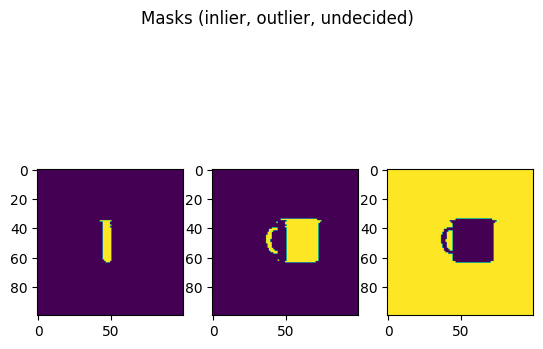

In [12]:
inliers, _, _, outliers, undecided, _ = PixelOutlier.get_rgb_depth_inliers_from_observed_rendered_args(gt_img, rgb_im_argmax, gt_depth, depth_im_argmax,  model_args)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Masks (inlier, outlier, undecided)')
ax1.imshow(inliers)
ax2.imshow(outliers)
ax3.imshow(undecided)

#### Save drawn pixel outlier model samples

In [13]:
b3d.make_gif_from_pil_images([b3d.overlay_image(Image.fromarray(np.array(original_view_image*255).astype(np.uint8)), Image.fromarray(np.array(gt_img*255).astype(np.uint8)))
                              for original_view_image in original_view_images], 'pixel_outlier_samples.gif'
)

### Ray outlier experiment

In [14]:
scores = []
inlier_scores = []
outlier_tele_scores = []
outlier_no_tele_scores = []

for batch in test_poses_batches:
    rgb_ims, depth_ims = renderer.render_attribute_many(
        (camera_pose.inv() @ batch)[:,None, ...],
        object_library.vertices,
        object_library.faces,
        object_library.ranges[jnp.array([0])],
        object_library.attributes,
    )

    color_error, depth_error = (100.0, 0.005)
    #inlier_score, outlier_prob = (5.0, 0.00001)
    inlier_score, outlier_prob = (25.0, 0.01)
    color_multiplier, depth_multiplier = (10000.0, 500.0)
    model_args = b3d.bayes3d.ModelArgs(
        color_error,
        depth_error,
        inlier_score,
        outlier_prob,
        color_multiplier,
        depth_multiplier,
    )

    scores_dict = ray_outlier_logpdfs(gt_img, gt_depth, rgb_ims, depth_ims, renderer.fx,renderer.fy, renderer.height, renderer.width, renderer.near, renderer.far, model_args)
    scores_batch = scores_dict['log_score']
    scores.append(scores_batch)
    inlier_scores.append(scores_dict['inlier_score'])
    outlier_tele_scores.append(scores_dict['outlier_teleport_score'])
    outlier_no_tele_scores.append(scores_dict['outlier_no_teleport_score'])

scores = jnp.concatenate(scores)
inlier_scores = jnp.concatenate(inlier_scores)
outlier_tele_scores = jnp.concatenate(outlier_tele_scores)
outlier_no_tele_scores = jnp.concatenate(outlier_no_tele_scores)
#scores = jnp.log(b3d.normalize_log_scores(scores))
samples = jax.random.categorical(key, scores, shape=(50,))

In [15]:
rr.log("observed_depth_no_background", rr.DepthImage(gt_depth))
gt_depth = jnp.where(gt_depth == 0.0, jnp.ones(gt_depth.shape)*renderer.far, gt_depth)


In [16]:
print("GT Contact Parameter :", gt_cp)

samples_deg_range = jnp.rad2deg(
    (
        jnp.max(delta_cps[samples], axis=0)
        - jnp.min(delta_cps[samples], axis=0)
    )[2]
)

print("Sampled Angle Range:", samples_deg_range)

alternate_camera_pose = Pose.from_position_and_target(
    jnp.array([0.01, 0.000, 0.9]), object_pose.pos
)
alternate_view_images, _ = renderer.render_attribute_many(
    (alternate_camera_pose.inv() @ test_poses[samples])[:, None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)


# print(samples_deg_range, sampled_degree_range_bounds[text_index][0], sampled_degree_range_bounds[text_index][1])
print(cp_delta_poses[jnp.argmax(scores)])


GT Contact Parameter : [0.        0.        3.1415927]
Sampled Angle Range: 66.85715
Pose(position=Array([0.00133333, 0.        , 0.        ], dtype=float32), quaternion=Array([0., 0., 0., 1.], dtype=float32))


### Pixel-score experiments

22225.041


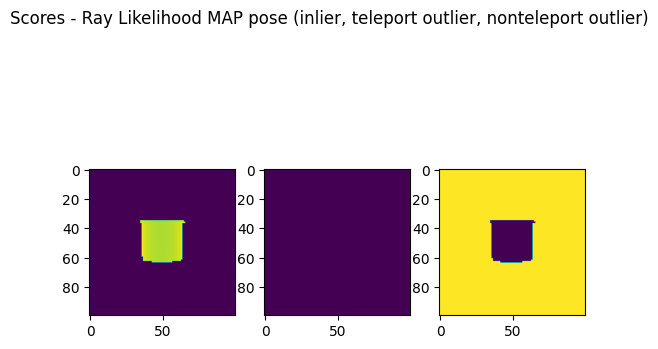

In [17]:
print(jnp.max(scores))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Scores - Ray Likelihood MAP pose (inlier, teleport outlier, nonteleport outlier)')
ax1.imshow(inlier_scores[jnp.argmax(scores)])
ax2.imshow(outlier_tele_scores[jnp.argmax(scores)])
ax3.imshow(outlier_no_tele_scores[jnp.argmax(scores)])

GT score: 22224.955


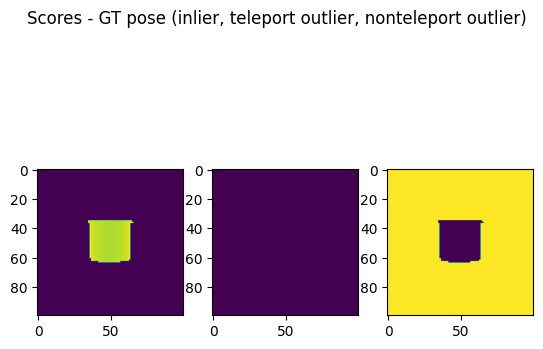

In [18]:
# rerender
gt_img_render, gt_depth_render = renderer.render_attribute(
    (camera_pose.inv() @ object_pose)[None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)
logpdf_gt = RayOutlier.logpdf(gt_img, gt_depth, gt_img_render, gt_depth_render, renderer.fx,renderer.fy, renderer.height, renderer.width, renderer.near, renderer.far, model_args)
print('GT score:', logpdf_gt['log_score'])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Scores - GT pose (inlier, teleport outlier, nonteleport outlier)')
ax1.imshow(logpdf_gt['inlier_score'])
ax2.imshow(logpdf_gt['outlier_teleport_score'])
ax3.imshow(logpdf_gt['outlier_no_teleport_score'])

In [19]:
#plt.imshow(logpdf_gt['outlier_no_teleport_score'])
jnp.sum(logpdf_gt['outlier_no_teleport_score'])

Array(9.198999, dtype=float32)

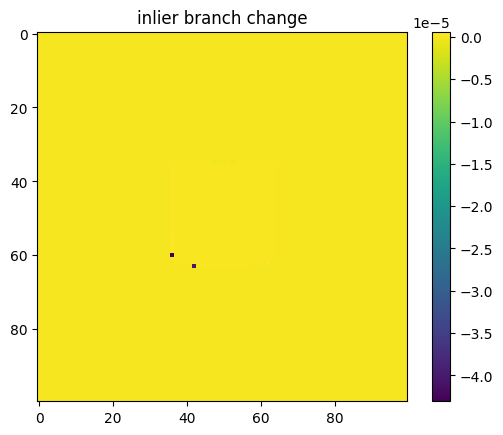

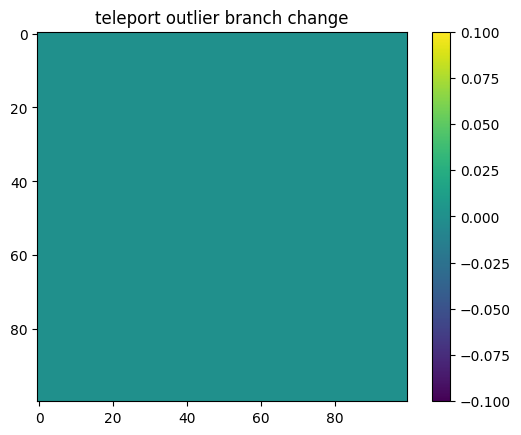

In [20]:
plt.figure()
plt.imshow(inlier_scores[jnp.argmax(scores)] - logpdf_gt['inlier_score'])
plt.title('inlier branch change')
plt.colorbar()
plt.figure()
plt.imshow(outlier_tele_scores[jnp.argmax(scores)] - logpdf_gt['outlier_teleport_score'])
plt.title('teleport outlier branch change')
plt.colorbar()

In [21]:
jnp.max(inlier_scores[jnp.argmax(scores)] - logpdf_gt['inlier_score'])

Array(6.213486e-07, dtype=float32)

In [22]:
jnp.min(inlier_scores[jnp.argmax(scores)] - logpdf_gt['inlier_score'])

Array(-4.306104e-05, dtype=float32)

In [23]:
jnp.max(outlier_tele_scores[jnp.argmax(scores)] - logpdf_gt['outlier_teleport_score'])

Array(0., dtype=float32)

In [24]:
print('inlier branch change:', jnp.sum(inlier_scores[jnp.argmax(scores)] - logpdf_gt['inlier_score']))
print('outlier teleport branch change:', jnp.sum(outlier_tele_scores[jnp.argmax(scores)] - logpdf_gt['outlier_teleport_score']))
print('outlier nonteleport branch change:', jnp.sum(outlier_no_tele_scores[jnp.argmax(scores)] - logpdf_gt['outlier_no_teleport_score']))

inlier branch change: 7.2808194e-05
outlier teleport branch change: 0.0
outlier nonteleport branch change: 6.714018e-06


Text(0.5, 1.0, 'Pixels where inlier score is lower under ray likelihood argmax than GT')

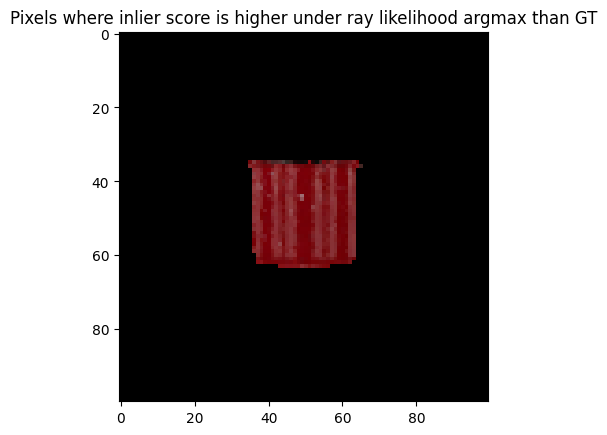

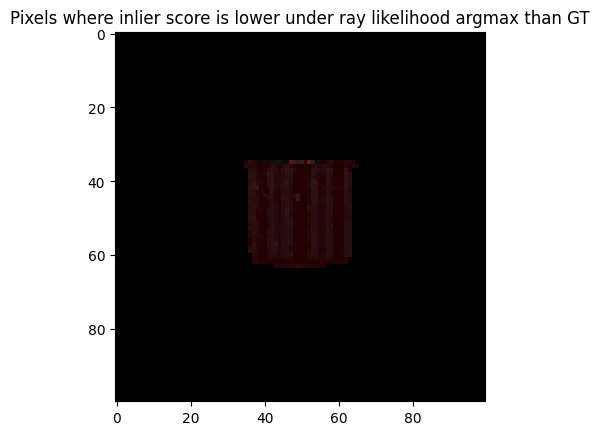

In [25]:
cam_rgb, _ = renderer.render_attribute(
    (camera_pose.inv() @ test_poses[jnp.argmax(scores)])[None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)

plt.figure()
plt.imshow(((inlier_scores[jnp.argmax(scores)] - logpdf_gt['inlier_score'])>0)[...,None] * cam_rgb * 0.7 + cam_rgb * .3)
plt.title('Pixels where inlier score is higher under ray likelihood argmax than GT')
plt.figure()
plt.imshow(((inlier_scores[jnp.argmax(scores)] - logpdf_gt['inlier_score'])<0)[...,None] * cam_rgb * 0.7 + cam_rgb * .3)
plt.title('Pixels where inlier score is lower under ray likelihood argmax than GT')

Text(0.5, 1.0, 'Pixels where teleport outlier score is lower under ray likelihood argmax than GT')

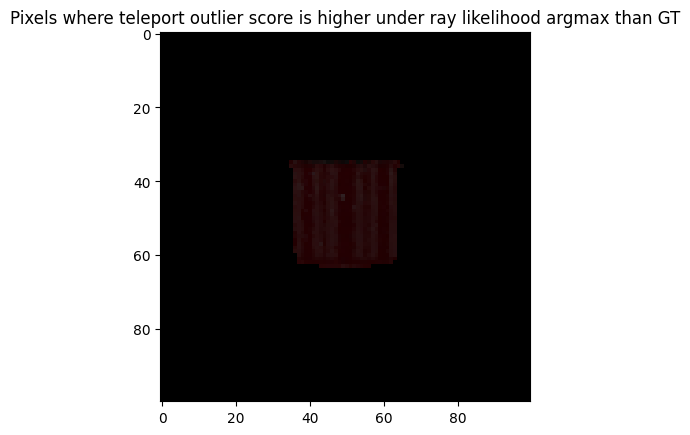

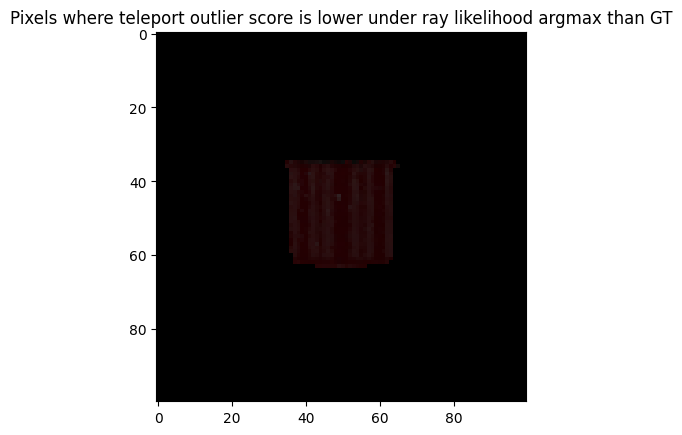

In [26]:
plt.figure()
plt.imshow(((outlier_tele_scores[jnp.argmax(scores)] - logpdf_gt['outlier_teleport_score'])>0)[...,None] * cam_rgb * 0.7 + cam_rgb * .3)
plt.title('Pixels where teleport outlier score is higher under ray likelihood argmax than GT')
plt.figure()
plt.imshow(((outlier_tele_scores[jnp.argmax(scores)] - logpdf_gt['outlier_teleport_score'])<0)[...,None] * cam_rgb * 0.7 + cam_rgb * .3)
plt.title('Pixels where teleport outlier score is lower under ray likelihood argmax than GT')

#### Conclusion: contribution to the score from a single inlier pixel is greater than the the scores summed across the entire mug handle. Can we fix this by tuning the branch parameters? Currently the score of the model with handle out is even higher than GT.

In [27]:
# plt.figure()
# plt.plot(b3d.normalize_log_scores(scores))
# plt.scatter(jnp.argsort(scores)[::-1][:10], b3d.normalize_log_scores(scores)[jnp.argsort(scores)[::-1][:10]], color='r')
# plt.title('enumerated grid and pdfs')
# plt.xlabel('grid sample')
# plt.ylabel('pdf value')

# plt.figure()
# plt.plot(b3d.normalize_log_scores(scores))
# plt.title('total score')
# plt.xlabel('grid_point')
# plt.ylabel('score')

# plt.figure()
# plt.plot(inlier_scores, label='inlier score')
# plt.plot(outlier_no_tele_scores, label='outlier no teleport score')
# plt.plot(outlier_tele_scores, label='outlier teleport score')
# plt.title('score contribution breakdown')
# plt.xlabel('grid_point')
# plt.ylabel('score (logprob)')
# plt.legend()


#### Inspect masks

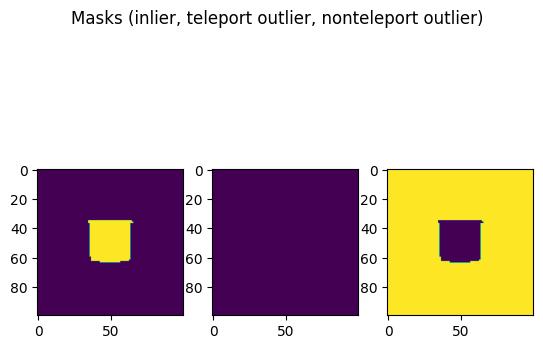

In [28]:
# generate inlier/outlier maps

original_view_im, original_view_depth = renderer.render_attribute(
    (camera_pose.inv() @ test_poses[jnp.argmax(scores)])[None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)

inliers, _, _, teleport_outliers, nonteleport_outliers, _ = RayOutlier.get_rgb_depth_inliers_from_observed_rendered_args(gt_img, original_view_im, gt_depth, original_view_depth,  model_args)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Masks (inlier, teleport outlier, nonteleport outlier)')
ax1.imshow(inliers)
ax2.imshow(teleport_outliers)
ax3.imshow(nonteleport_outliers)

#### Save drawn ray outlier model samples

In [29]:
original_view_images, _ = renderer.render_attribute_many(
    (camera_pose.inv() @ test_poses[samples])[:, None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)


b3d.make_gif_from_pil_images([b3d.overlay_image(Image.fromarray(np.array(original_view_image*255).astype(np.uint8)), Image.fromarray(np.array(gt_img*255).astype(np.uint8)))
                              for original_view_image in original_view_images], 'ray_outlier_samples.gif'
)

In [30]:
original_view_images, _ = renderer.render_attribute_many(
    (camera_pose.inv() @ test_poses[jnp.argsort(scores)[::-1][:50]])[:, None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)


b3d.make_gif_from_pil_images([b3d.overlay_image(Image.fromarray(np.array(original_view_image*255).astype(np.uint8)), Image.fromarray(np.array(gt_img*255).astype(np.uint8)))
                              for original_view_image in original_view_images], 'ray_outlier_ranked.gif')